In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
data = pd.read_csv('ebw_data.csv')

In [4]:
data.head(5)

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


In [5]:
data.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [6]:
data.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


In [7]:
y = np.array(data[['Depth', 'Width']])

In [8]:
y[:5]

array([[1.6 , 2.54],
       [1.62, 2.5 ],
       [1.68, 2.6 ],
       [1.58, 2.52],
       [1.76, 2.48]])

In [9]:
X = np.array(data[['IW','IF','VW','FP']])

In [10]:
X[:5]

array([[ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 47. , 139. ,   4.5,  80. ],
       [ 45. , 140. ,   4.5,  80. ]])

In [11]:
scaler = StandardScaler().fit(X)

In [12]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [13]:
X_scaled = scaler.transform(X)

In [14]:
X_scaled[:5]

array([[ 0.8       , -0.45662965, -2.02221044,  0.07808688],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688],
       [ 0.8       , -0.45662965, -2.02221044,  0.07808688],
       [-0.4       , -0.26093123, -2.02221044,  0.07808688]])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True)

In [16]:
linear_model = LinearRegression().fit(X_train, y_train)

In [17]:
pickle.dump(linear_model, open('linear_model.pkl', 'wb'))

In [18]:
y_pred = linear_model.predict(X_test)

In [19]:
y_pred

array([[1.17067059, 1.75734382],
       [0.88049778, 2.32016028],
       [1.21633095, 1.88023529],
       [1.21633095, 1.88023529],
       [1.264694  , 1.86208295],
       [0.88049778, 2.32016028],
       [1.21633095, 1.88023529],
       [1.264694  , 1.86208295],
       [1.264694  , 1.86208295],
       [1.56844254, 2.51704106],
       [1.27511489, 2.03573655],
       [1.2429573 , 1.82398554],
       [1.2429573 , 1.82398554],
       [0.9425576 , 1.96801903],
       [1.2429573 , 1.82398554]])

In [20]:
y_test

array([[1.08, 1.82],
       [0.8 , 2.24],
       [1.12, 1.8 ],
       [1.12, 1.76],
       [1.32, 1.76],
       [0.84, 2.28],
       [1.18, 1.78],
       [1.36, 1.76],
       [1.28, 1.76],
       [1.62, 2.5 ],
       [1.2 , 1.96],
       [1.2 , 1.76],
       [1.2 , 1.86],
       [0.96, 1.94],
       [1.2 , 1.76]])

In [21]:
mean_squared_error(y_test, y_pred)

0.005106751313056308

In [22]:
mean_absolute_error(y_test, y_pred)

0.06514257690963039

In [23]:
r2_score(y_test, y_pred)

0.8872362234085032

In [25]:
y_depth = y[:,0]

In [26]:
y_depth

array([1.6 , 1.62, 1.68, 1.58, 1.76, 1.72, 1.64, 1.64, 1.2 , 1.2 , 1.16,
       1.2 , 0.98, 1.02, 1.04, 1.  , 1.2 , 1.  , 1.2 , 1.16, 1.12, 1.08,
       1.2 , 1.08, 0.96, 0.96, 0.92, 0.94, 1.36, 1.36, 1.4 , 1.36, 0.84,
       0.86, 0.88, 0.8 , 0.84, 0.84, 0.8 , 0.8 , 1.12, 1.22, 1.12, 1.18,
       1.28, 1.36, 1.36, 1.24, 1.28, 1.32, 1.24, 1.32, 1.08, 1.08, 1.08,
       1.08, 1.2 , 1.2 , 1.2 , 1.2 , 1.2 , 1.24, 1.2 , 1.24, 1.16, 1.2 ,
       1.24, 1.2 , 1.36, 1.28, 1.28, 1.32])

In [27]:
y_width = y[:, 1]

In [28]:
y_width

array([2.54, 2.5 , 2.6 , 2.52, 2.48, 2.48, 2.52, 2.56, 2.  , 1.96, 1.96,
       1.96, 1.84, 1.84, 1.9 , 1.86, 1.78, 1.84, 1.86, 1.8 , 1.71, 1.68,
       1.8 , 1.72, 2.  , 1.94, 1.86, 1.94, 2.52, 2.48, 2.48, 2.48, 2.16,
       2.08, 2.  , 2.04, 2.28, 2.24, 2.24, 2.28, 1.76, 1.82, 1.8 , 1.78,
       1.8 , 1.76, 1.76, 1.76, 1.8 , 1.84, 1.8 , 1.96, 1.8 , 1.82, 1.82,
       1.82, 1.76, 1.86, 1.88, 1.76, 1.76, 1.8 , 1.72, 1.78, 1.76, 1.68,
       1.72, 1.72, 1.76, 1.76, 1.76, 1.76])

In [321]:
X_train_depth, X_test_depth, y_train_depth, y_test_depth = train_test_split(X_scaled, y_depth, test_size=0.2, shuffle=True)

In [322]:
X_train_width, X_test_width, y_train_width, y_test_width = train_test_split(X_scaled, y_width, test_size=0.2, shuffle=True)

In [323]:
depthLinModel = LinearRegression().fit(X_train_depth, y_train_depth)

In [324]:
widthLinMocel = LinearRegression().fit(X_train_width, y_train_width)

In [325]:
depth_pred = depthLinModel.predict(X_test_depth)

In [326]:
width_pred = widthLinMocel.predict(X_test_width)

In [327]:
depth_pred, y_test_depth

(array([1.21357392, 1.58824903, 1.2213787 , 1.24298575, 1.24298575,
        1.23237354, 1.25359796, 1.58824903, 1.24298575, 1.30142678,
        0.95205475, 1.11178334, 1.30142678, 1.2213787 , 1.24298575]),
 array([1.36, 1.62, 1.22, 1.16, 1.2 , 1.2 , 1.32, 1.36, 1.32, 1.16, 0.94,
        0.98, 1.2 , 1.12, 1.28]))

In [328]:
width_pred, y_test_width

(array([1.76405357, 2.43730915, 2.49673426, 1.81647117, 1.82629905,
        2.04016959, 2.49673426, 1.84938219, 2.31595685, 1.81647117,
        1.81647117, 1.62273078, 1.81647117, 2.49673426, 2.43730915]),
 array([1.76, 2.48, 2.48, 1.76, 1.84, 2.  , 2.48, 1.76, 2.28, 1.96, 1.68,
        1.72, 1.8 , 2.48, 2.56]))

In [329]:
r2_score(depth_pred, y_test_depth), r2_score(width_pred, y_test_width)

(0.5501547025450274, 0.9473022458237828)

In [24]:
# нейросетОЧКА
import tensorflow as tf

In [25]:
NN_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=100, activation='sigmoid'),
    tf.keras.layers.Dense(units=2)
])

NN_model.compile(loss=tf.keras.losses.mean_absolute_error,
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])


In [26]:
history = NN_model.fit(
    X_scaled,
    y,
    epochs=200,
    verbose=0,
    validation_data=(X_test,y_test)
)

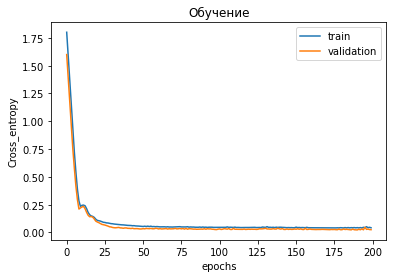

In [27]:
# визуализация`
plt.title('Обучение')
plt.xlabel('epochs')
plt.ylabel('Cross_entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [28]:
y_pred = NN_model.predict(X_test)

1/1 [==============================] - 0s 93ms/step


In [29]:
y_pred

array([[1.1679316 , 1.7957197 ],
       [0.8501172 , 2.2568154 ],
       [1.187828  , 1.7829438 ],
       [1.187828  , 1.7829438 ],
       [1.3143833 , 1.7619566 ],
       [0.8501172 , 2.2568154 ],
       [1.187828  , 1.7829438 ],
       [1.3143833 , 1.7619566 ],
       [1.3143833 , 1.7619566 ],
       [1.5698545 , 2.4860506 ],
       [1.2307243 , 1.9573311 ],
       [1.214016  , 1.7646395 ],
       [1.214016  , 1.7646395 ],
       [0.96833426, 1.9425948 ],
       [1.214016  , 1.7646395 ]], dtype=float32)

In [30]:
y_test

array([[1.08, 1.82],
       [0.8 , 2.24],
       [1.12, 1.8 ],
       [1.12, 1.76],
       [1.32, 1.76],
       [0.84, 2.28],
       [1.18, 1.78],
       [1.36, 1.76],
       [1.28, 1.76],
       [1.62, 2.5 ],
       [1.2 , 1.96],
       [1.2 , 1.76],
       [1.2 , 1.86],
       [0.96, 1.94],
       [1.2 , 1.76]])

In [31]:
mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)

(0.02484883093833923, 0.9691749716043132)

In [32]:
scaler.transform(np.array([[46., 141., 10.0, 80.]]))

array([[ 0.2       , -0.06523281,  0.66502222,  0.07808688]])

In [33]:
X_scaled[19], y[19]

(array([ 0.2       , -0.06523281,  0.66502222,  0.07808688]),
 array([1.16, 1.8 ]))

In [34]:
NN_model.predict(scaler.transform(np.array([[46., 141., 10.0, 80.]])))

1/1 [==============================] - 0s 22ms/step


array([[1.144333 , 1.7968535]], dtype=float32)

In [35]:
NN_model.predict(scaler.transform(np.array([[47., 134., 10.0, 110.]])))

1/1 [==============================] - 0s 24ms/step


array([[0.9683344, 1.942595 ]], dtype=float32)

In [36]:
X_scaled[27], y[27]

(array([ 0.8       , -1.43512176,  0.66502222,  1.48365074]),
 array([0.94, 1.94]))

In [37]:
NN_model.save('nn_model')

INFO:tensorflow:Assets written to: nn_model\assets


In [38]:
loaded_model = tf.keras.models.load_model('nn_model')

In [39]:
loaded_model.predict(scaler.transform(np.array([[47., 134., 10.0, 110.]])))

1/1 [==============================] - 0s 192ms/step


array([[0.9683344, 1.942595 ]], dtype=float32)

In [40]:
from sklearn.ensemble import RandomForestRegressor

In [41]:
forest_model = RandomForestRegressor()

In [42]:
forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [47]:
pickle.dump(forest_model, open('forest_model.pkl', 'wb'))

In [43]:
y_pred = forest_model.predict(X_test)

In [44]:
y_pred

array([[1.0829697 , 1.81137052],
       [0.82540667, 2.23340667],
       [1.19535333, 1.83332611],
       [1.19535333, 1.83332611],
       [1.26327906, 1.77378789],
       [0.82540667, 2.23340667],
       [1.19535333, 1.83332611],
       [1.26327906, 1.77378789],
       [1.26327906, 1.77378789],
       [1.48159483, 2.51935084],
       [1.17786381, 1.96805825],
       [1.23931954, 1.79351956],
       [1.23931954, 1.79351956],
       [0.93457619, 1.94984714],
       [1.23931954, 1.79351956]])

In [45]:
y_test

array([[1.08, 1.82],
       [0.8 , 2.24],
       [1.12, 1.8 ],
       [1.12, 1.76],
       [1.32, 1.76],
       [0.84, 2.28],
       [1.18, 1.78],
       [1.36, 1.76],
       [1.28, 1.76],
       [1.62, 2.5 ],
       [1.2 , 1.96],
       [1.2 , 1.76],
       [1.2 , 1.86],
       [0.96, 1.94],
       [1.2 , 1.76]])

In [46]:
r2_score(y_pred, y_test)

0.9290104584657077

In [91]:
from sklearn.linear_model import Ridge

In [105]:
alphas = []
r2s = []

for i in np.arange(0.0001, 10.0, 0.0001):
    alphas.append(i)
    model = Ridge(alpha=i)
    model.fit(X_train, y_train)
    r2s.append(r2_score(model.predict(X_test), y_test))

In [106]:
np.argmax(r2s)

0

In [107]:
np.max(r2s)
r2s[:5]

[0.8640637537821696,
 0.8640507395845329,
 0.8640377186008433,
 0.8640246908384877,
 0.8640116563048448]